In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii


# This notebook: 
<ol>
<li>Creates a mask </li>
<li>Writes GalFit Input file</li>
<li>Visualizes GalFit output</li>
</ol>

In [2]:
#Bruno's github codes

def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}


def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return


#amended code

def select_object_segmap(segmap,index):
    Regions = np.zeros_like(segmap)
    if index not in segmap:
        raise ValueError('index not in segmentation map')
    Regions[segmap==index]=index
    return Regions

In [3]:
#to easily cycle thru all filters....PART ONE

def usingfilter(filtername):
    #filter = filtername
    detected_objs_file_table = ascii.read('/data1/rowland/testPSF_{}.cat'.format(filtername))
    image_file = pyfits.open('/data1/rowland/elgordo_{}.fits'.format(filtername))
    segmap_file = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filtername))
    data_perfilter = detected_objs_file_table, image_file, segmap_file, filtername
    return(data_perfilter)

# Choose Filter Here

In [5]:
#to easily cycle thru all filters....PART TWO


filters = ["F105W","F125W","F140W","F160W","F435W","F606W","F625W","F775W","F814W","F850LP","F105W_galfit_test_folder"]
zeropoints = {"F435W":25.665,"F606W":26.493,"F814W":25.97,"F105W":26.2687,"F125W":26.2303,"F140W":24.4524,\
              "F160W":25.9463, "F625W":24.85714771, "F775W":25.66195995, "F850LP":25.89943399}

#ONLY CHANGES NEEDED: FILTER HERE, ADJUST B1&B2 VALUES & MAG CUT AS NEEDED
############################################################################
data = usingfilter(filters[0])
############################################################################
print('Currently using this filter:',data[3])

Currently using this filter: F105W


In [6]:
#defing the chosen filters data to use throughout code below


detected_objs_file = data[0]
image_file = data[1]
segmap_file = data[2]
filtername = data[3]

### Subselecting Galaxies of the Cluster

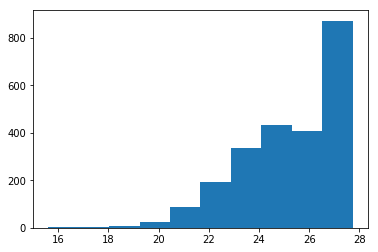

In [6]:
#test for where to put mag cut


mpl.hist(detected_objs_file['MAG_AUTO'])
mpl.show()

In [7]:
#quick cut based on magnitudes to get brightest BUT theres stars in here!, need further cut


#MAY want to change depending on above histogram
##############################################################################
short_detections_intermediate = np.where(detected_objs_file['MAG_AUTO']<20) 
##############################################################################
short_detections_stillstarstho = detected_objs_file[short_detections_intermediate]
short_detections_stillstarstho

NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,mag,,pix2,pix,pix,pix,pix,deg,deg,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
49,16.8159,0.0099,3.5,2907,2069,687,2069.7666,686.6608,15.7396822,-49.2898555,4.373,-1.29,15.7178,0.068,0.998,2.576
70,18.2507,0.0191,3.5,6022,1667,842,1667.3851,842.0582,15.7499635,-49.2872646,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,0.0404,4.81,3040,1545,1218,1545.1145,1218.0986,15.7530854,-49.2809968,13.518,59.61,21.059,0.309,0.922,16.019
286,19.0743,0.028,3.5,964,2836,1258,2835.8049,1257.6709,15.7201102,-49.2803378,3.552,-15.97,17.9312,0.079,0.975,2.516
413,18.509,0.0216,3.64,6377,2023,1761,2022.579,1761.2362,15.7408857,-49.2719458,18.282,42.21,20.0029,0.441,0.107,13.258
738,17.1776,0.0117,3.5,2360,3043,2098,3043.8003,2097.4651,15.7148019,-49.2663405,4.078,-7.54,15.7596,0.027,0.976,2.295
815,19.5938,0.0355,3.5,1797,2039,2057,2039.0352,2056.7297,15.7404647,-49.267021,10.212,-21.72,19.837,0.524,0.87,6.32
859,19.7286,0.0378,3.5,653,905,2091,905.2455,2091.0654,15.7694229,-49.2664436,3.394,5.5,18.6888,0.175,0.958,2.545


RED line is B1, BLUE line is B2
Above red line are galaxies, between red & blue are stars


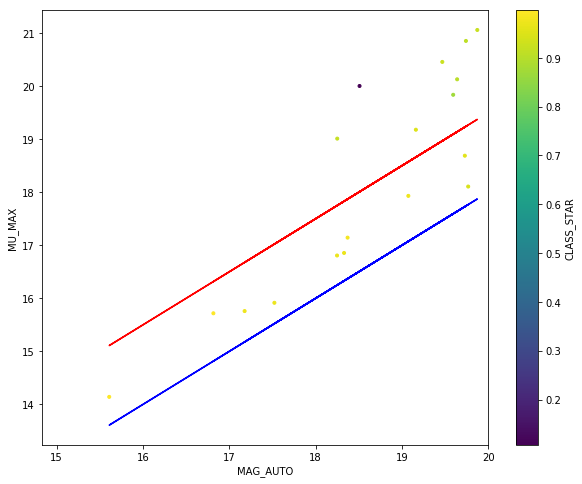

In [9]:
# seperating stars from galaxies in above list (using psf code tricks)


%matplotlib inline
####################################################################adjust as needed
B1 = .5 #red
B2 = 2 #blue
#######################################################################
print('RED line is B1, BLUE line is B2')
print('Above red line are galaxies, between red & blue are stars')

fig,ax = mpl.subplots(figsize=(10,8))
S = ax.scatter(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MU_MAX"], \
               c =short_detections_stillstarstho["CLASS_STAR"], marker=".")
P2 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B1,color='r')
P1 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B2,color='b')
ax.set_xlim(0.95*min(short_detections_stillstarstho["MAG_AUTO"]),20)
ax.set_xlabel("MAG_AUTO")
ax.set_ylabel("MU_MAX")
CLB = mpl.colorbar(S,ax=ax)
CLB.set_label("CLASS_STAR")
mpl.show()

In [10]:
#only selecting the galaxies


galselection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] > (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_ofgalaxies = short_detections_stillstarstho[galselection_intermediate1]
print('selection of galaxies:')
selection_ofgalaxies #= selection_ofgalaxies.astype(np.int16) #goes from boolean to binary

selection of galaxies:


NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,mag,,pix2,pix,pix,pix,pix,deg,deg,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70,18.2507,0.0191,3.5,6022,1667,842,1667.3851,842.0582,15.7499635,-49.2872646,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,0.0404,4.81,3040,1545,1218,1545.1145,1218.0986,15.7530854,-49.2809968,13.518,59.61,21.059,0.309,0.922,16.019
413,18.509,0.0216,3.64,6377,2023,1761,2022.579,1761.2362,15.7408857,-49.2719458,18.282,42.21,20.0029,0.441,0.107,13.258
815,19.5938,0.0355,3.5,1797,2039,2057,2039.0352,2056.7297,15.7404647,-49.267021,10.212,-21.72,19.837,0.524,0.87,6.32
1429,19.4677,0.0335,3.81,3475,2802,2912,2801.2766,2912.0305,15.7209999,-49.2527653,13.029,28.94,20.4566,0.171,0.926,11.545
1450,19.7413,0.038,4.3,2001,2744,2911,2744.5549,2911.6685,15.7224483,-49.2527715,11.035,52.73,20.8523,0.306,0.91,11.93
1506,19.6395,0.0363,4.08,2239,3402,2972,3401.614,2972.3813,15.7056715,-49.2517566,9.69,30.0,20.1289,0.21,0.906,8.879
1839,19.1615,0.0291,3.5,2037,2692,3408,2692.2927,3408.125,15.7237845,-49.2444973,11.211,-54.49,19.1786,0.61,0.952,6.201


In [10]:
#to select likely stars only

 
#keeping them tables
selection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] < (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_intermediate2 = short_detections_stillstarstho[selection_intermediate1]
selection_intermediate3 = np.where(selection_intermediate2["MU_MAX"] > (selection_intermediate2["MAG_AUTO"]-B2))
selection_ofstars = selection_intermediate2[selection_intermediate3]
print('selection of stars:')
selection_ofstars #= selection.astype(np.int16) #goes from boolean to binary

selection of stars:


NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,mag,,pix2,pix,pix,pix,pix,deg,deg,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
49,16.8159,0.0099,3.5,2907,2069,687,2069.7666,686.6608,15.7960822,-49.3159164,4.373,-1.29,15.7178,0.068,0.998,2.576
286,19.0743,0.028,3.5,964,2836,1258,2835.8049,1257.6709,15.7830189,-49.3095784,3.552,-15.97,17.9312,0.079,0.975,2.516
738,17.1776,0.0117,3.5,2360,3043,2098,3043.8003,2097.4651,15.7794651,-49.3002489,4.078,-7.54,15.7596,0.027,0.976,2.295
859,19.7286,0.0378,3.5,653,905,2091,905.2455,2091.0654,15.8159042,-49.3002992,3.394,5.5,18.6888,0.175,0.958,2.545
915,18.3705,0.0202,3.5,1413,3375,2204,3374.6672,2204.7578,15.7738264,-49.2990589,3.702,-34.61,17.144,0.042,0.981,2.326
1247,15.6094,0.0057,3.5,6617,2561,2849,2560.8123,2848.3591,15.7876853,-49.2919019,5.342,23.41,14.1421,0.053,0.998,2.197
1504,18.3298,0.0198,3.5,823,2759,2899,2758.7595,2898.4578,15.7843124,-49.2913468,3.39,-88.28,16.8555,0.15,0.972,2.184
1572,17.5226,0.0137,3.5,2075,2610,3048,2609.9658,3047.9929,15.7868454,-49.2896842,3.956,-17.46,15.9158,0.029,0.971,2.143


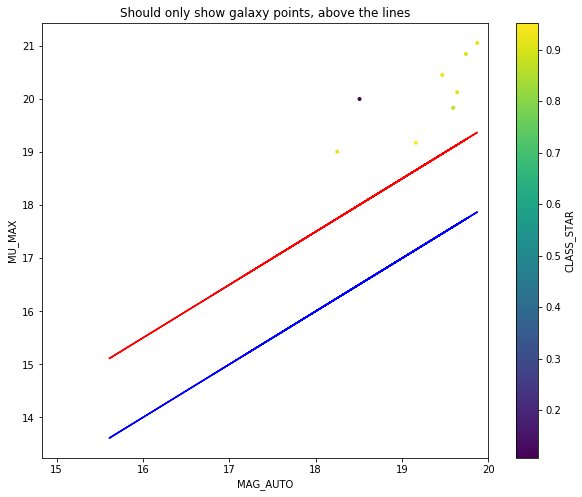

In [11]:
#checking if above cut was good enough


fig,ax = mpl.subplots(figsize=(10,8))
S = ax.scatter(selection_ofgalaxies["MAG_AUTO"],selection_ofgalaxies["MU_MAX"], \
               c =selection_ofgalaxies["CLASS_STAR"], marker=".")
P2 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B1,color='r')
P1 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B2,color='b')


#use below if id stars if have to manually exclude after verifcation plots below
''' 
###########################################################################################
P3 = ax.scatter(selection_ofgalaxies[1]['MAG_AUTO'],selection_ofgalaxies[1]["MU_MAX"], \
               c =selection_ofgalaxies[1]["CLASS_STAR"], marker="+")
P4 = ax.scatter(selection_ofgalaxies[2]['MAG_AUTO'],selection_ofgalaxies[2]["MU_MAX"], \
               c =selection_ofgalaxies[2]["CLASS_STAR"], marker="+")
P5 = ax.scatter(selection_ofgalaxies[10]['MAG_AUTO'],selection_ofgalaxies[10]["MU_MAX"], \
               c =selection_ofgalaxies[10]["CLASS_STAR"], marker="+")
P6 = ax.scatter(selection_ofgalaxies[11]['MAG_AUTO'],selection_ofgalaxies[11]["MU_MAX"], \
               c =selection_ofgalaxies[11]["CLASS_STAR"], marker="+")
##########################################################################################
''' 

ax.set_xlim(0.95*min(short_detections_stillstarstho["MAG_AUTO"]),20)
ax.set_xlabel("MAG_AUTO")
ax.set_ylabel("MU_MAX")
ax.set_title('Should only show galaxy points, above the lines')
CLB = mpl.colorbar(S,ax=ax)
CLB.set_label("CLASS_STAR")
mpl.show()


In [12]:
# use if have stars needing manual exclusion---REMEMBER TO ONLY RUN ONCE

''' 
#######################################################################
selection_ofgalaxies.remove_rows([1,2]) #cut out stars indices
selection_ofgalaxies
######################################################################
'''

' \n#######################################################################\nselection_ofgalaxies.remove_rows([1,2]) #cut out stars indices\nselection_ofgalaxies\n######################################################################\n'

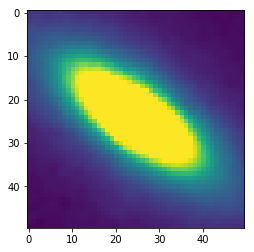

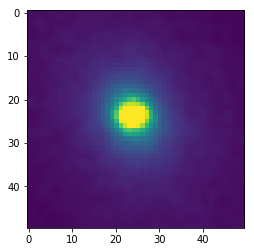

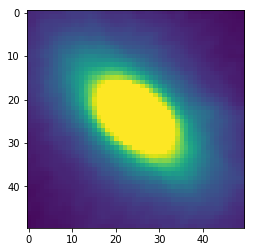

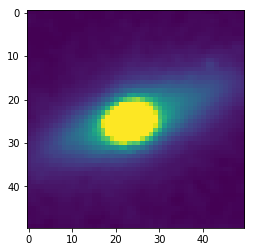

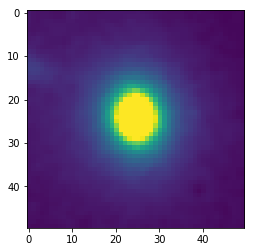

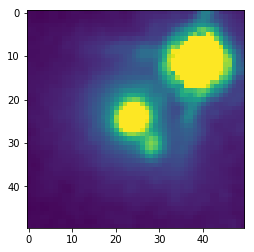

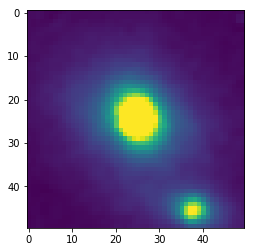

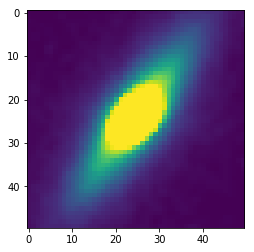

In [13]:
#verifying that stars are stars & galaxies are galaxies 


image_data = image_file[0].data #PARAMETER
for image in selection_ofgalaxies: #CHANGE SELECTION_OF... TO SEE STARS V GALAXIES
    x = image['X_IMAGE'].astype(np.int)
    y = image['Y_IMAGE'].astype(np.int)
    width = 25
    fig = mpl.figure()
    mpl.imshow(image_data[y-width:y+width,x-width: x+width ], vmin=0,vmax=1)

# 1. Creating MASK of cluster's galaxies

In [14]:
#selecting pixel locations of cluster's galaxies


segmap = segmap_file[0].data+0 #PARAMETER
collected_regions = []

for detection in selection_ofgalaxies: 
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"] #in pix #PARAMETER
    pixscale = 0.06 #PARAMETER
    index = detection['NUMBER']
    #radius=0.5 ##DEFAULT value for reference #PARAMETER
    each_region = select_object_segmap(segmap,index) #indexing so have matching value so subtracting =0
    collected_regions.append(each_region)
collected_regions = np.array(collected_regions)
print('collected_regions: type-',type(collected_regions), 'shape-',collected_regions.shape)    
final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
print('shape of final regions:',final_regions.shape)

collected_regions: type- <class 'numpy.ndarray'> shape- (8, 4824, 4538)
shape of final regions: (4824, 4538)


In [15]:
#creating mask


#subtracting
mask_file = segmap - final_regions #so the galaxies of the cluster have value=0

#setting values to be binary, all none cluster galaxy pixels are =1 (so galfit will ignore)
mask_file[np.where(mask_file > 0)]=1
#setting regions outside of observation to =1
mask_file[image_data==0]=1

### Verifying MASK works

In [16]:
#if want to zoom in quickly to see removed galaxies

''' 
#getting tuples of coordinates for galaxies so can easily amend below code to zoom to each
object_coords = []
for detection in selection_ofgalaxies: #[1:3]:#[10:12]:
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"]
    coords = (xc,yc)
    object_coords.append(coords)

#not efficient but w/e
############################################################################################
#change based on number of galaxies selected above
############################################################################################
#for 1st detection
xc0 = object_coords[0][0]
yc0 = object_coords[0][1]
#for 2nd detection
xc1 = object_coords[1][0]
yc1 = object_coords[1][1]
#for 3rd detection
xc2 = object_coords[2][0]
yc2 = object_coords[2][1]
#for 4th detection
xc3 = object_coords[3][0]
yc3 = object_coords[3][1]
#for 5th detection
xc4 = object_coords[4][0]
yc4 = object_coords[4][1]
#for 6th detection
xc5 = object_coords[5][0]
yc5 = object_coords[5][1]
#for 7th detection
xc6 = object_coords[6][0]
yc6 = object_coords[6][1]
 #for 8th detection
xc7 = object_coords[7][0]
yc7 = object_coords[7][1]
'''

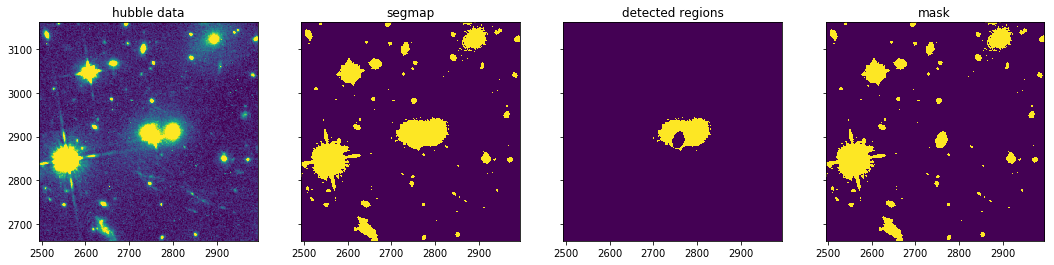

In [17]:
#plotting all
fig, axis = mpl.subplots(1,4,figsize=(18,8),sharex=True,sharey=True)
axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)
axis[0].set_title('hubble data')
axis[1].imshow(segmap,vmin=0,vmax=1)
axis[1].set_title('segmap')
axis[2].imshow(final_regions,vmin=0, vmax=1)
axis[2].set_title('detected regions')
axis[3].imshow(mask_file,vmin=0,vmax=1)
axis[3].set_title('mask')


''' 
#amend above cell to zoom by detection
for ax in axis:
    #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
    w = 250
    #see above cell for meanings
    xc = xc5
    yc = yc5
    ax.set_xlim(xc-w,xc+w)
    ax.set_ylim(yc-w,yc+w)
'''

### Creating a Dilated MASK

In [18]:
#smoothing (ie increasing mask coverage to balance higher inital thresh when running SEx)


dilated_mask = sci_nd.binary_dilation(mask_file,structure=np.ones([3,3])).astype(np.int16)

### Saving MASK files

In [19]:
#saving files for a config run of galfit later


pyfits.writeto('/data1/rowland/{}/dilated_mask.fits'.format(filtername),dilated_mask,overwrite=True)
pyfits.writeto('/data1/rowland/{}/undilated_mask.fits'.format(filtername),mask_file,overwrite=True)

# 2. Writing GalFit Input files for detections (each galaxy in cluster)

In [11]:
#collecting data of detections i want galfit to fit (ie cluster galaxies)


model = 'sersic' #from bruno
modelsList = [] #FOR INDIVIDUAL DETECTIONS
object_numbers = []
xs = []
ys = []
modelsString = [] #FOR ALL DETECTIONS 

for detection in selection_ofgalaxies: #to only run on subset for testing
    ## DEFINING PARAMETERS
    num = detection['NUMBER'] #object detection number from SEx list
    ba = 1 - detection['ELLIPTICITY'] 
    pa = 90 - detection['THETA_IMAGE'] 
    x = detection['X_IMAGE'] 
    y = detection['Y_IMAGE']
    re = detection['FLUX_RADIUS']
    m = detection['MAG_AUTO']
    n = 4     #this is sersic index, 4 b/c mostly expecting distinct cores & extended disks
    list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
    object_numbers.append(num)
    xs.append(x) #so i can slice these the same as modelsList in next cell
    ys.append(y)
    modelsList.append(list_of_strings) #FOR INDIVIDUAL DETECTIONS INPUT FILES
    modelsString = ''.join(modelsList) #FOR ALL DETECTIONS INPUT FILE

In [15]:
print(modelsList[0])

#Object number: 70
 0) sersic             # Object type
 1) 1667.3851 842.0582  1 1    # position x, y        [pixel]
 3) 18.2507      1       # total magnitude
 4) 9.8930       1       #     R_e              [Pixels]
 5) 4.0000       1       # Sersic exponent (deVauc=4, expdisk=1)
 9) 0.4730       1       # axis ratio (b/a)   
10) 52.7800       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)
 



### Inputs for INDIVIDUAL galaxies

In [21]:
#this makes a galfit input file per detection but indexes them 1:len(detections), not by object number


for count, item in enumerate(modelsList, 0): #started at 0 to index x,y correctly
    with open(f'/data1/rowland/{filtername}/input_{count}.txt', 'w') as f: ####would manually change FILTER folder here
        magzpt = zeropoints[filtername] #from zeropoints for this filter
        sky = 0 #b/c images already background subtracted
        width = 150
        #indexing by order of detection (enumerate(object num in low to high order))
        x_range = (xs[count]-width,xs[count]+width) 
        y_range = (ys[count]-width, ys[count]+width)
        sconvbox = 100 #55 is closer to psf size #100 
        pixscale = 0.06
        strings_forgalfit = input_file(f,item,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                                       imgname='elgordo_{}.fits'.format(filtername),\
                                       outname="output{}.fits".format(count),\
                                       psfname='psf.fits',\
                                       maskname='dilated_mask_{}.fits'.format(filtername),\
                                       signame='none',fixpars=None)    

### Inputs for ALL galaxies

In [22]:
#this makes a galfit input file for entire filter's detections 


f_all = open("/data1/rowland/{}/input_{}_ALL.galfit".format(filtername,filtername), "w") #created a blank file to write to
magzpt = zeropoints[filtername] #from zeropoints for this filter
sky = 0 #b/c images already background subtracted
x_range =  (0,4538) #from image_file[0].data.shape (x,y)
y_range = (0,4824)  #from image_file[0].data.shape (x,y)
sconvbox = 100 #(4824, 4538)
pixscale = 0.06
strings_forgalfit = input_file(f_all,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                               imgname='elgordo_{}.fits'.format(filtername),\
                               outname="output_{}_ALL.fits".format(filtername),\
                               psfname='psf.fits',\
                               maskname='dilated_mask_{}.fits'.format(filtername),\
                               signame='none',fixpars=None)

### MOVE "testPSF_filter.cat" & "elgordo_filter.fits"  (into the input file folder above)
# RUN GALFIT in terminal
### THEN

# 3. To view all images per INDIVIDUAL galaxy: uncomment below

0
1


/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


2
3
4
5
6
7


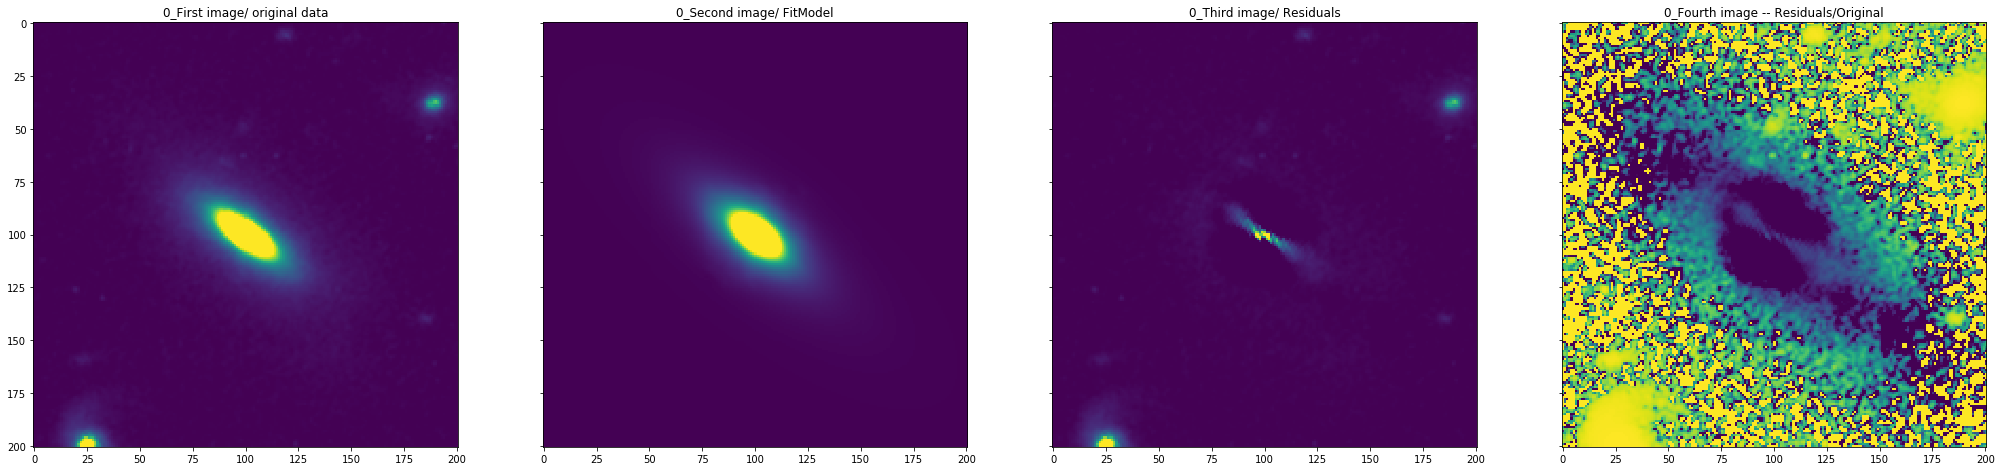

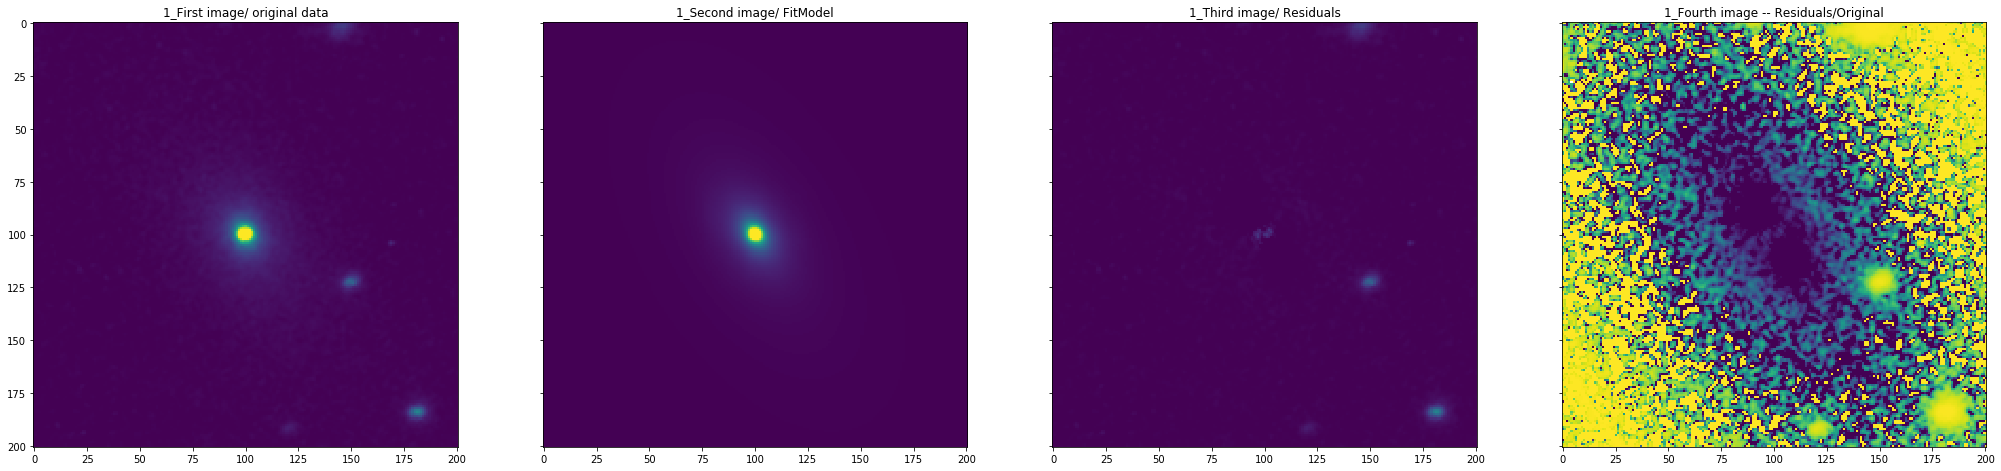

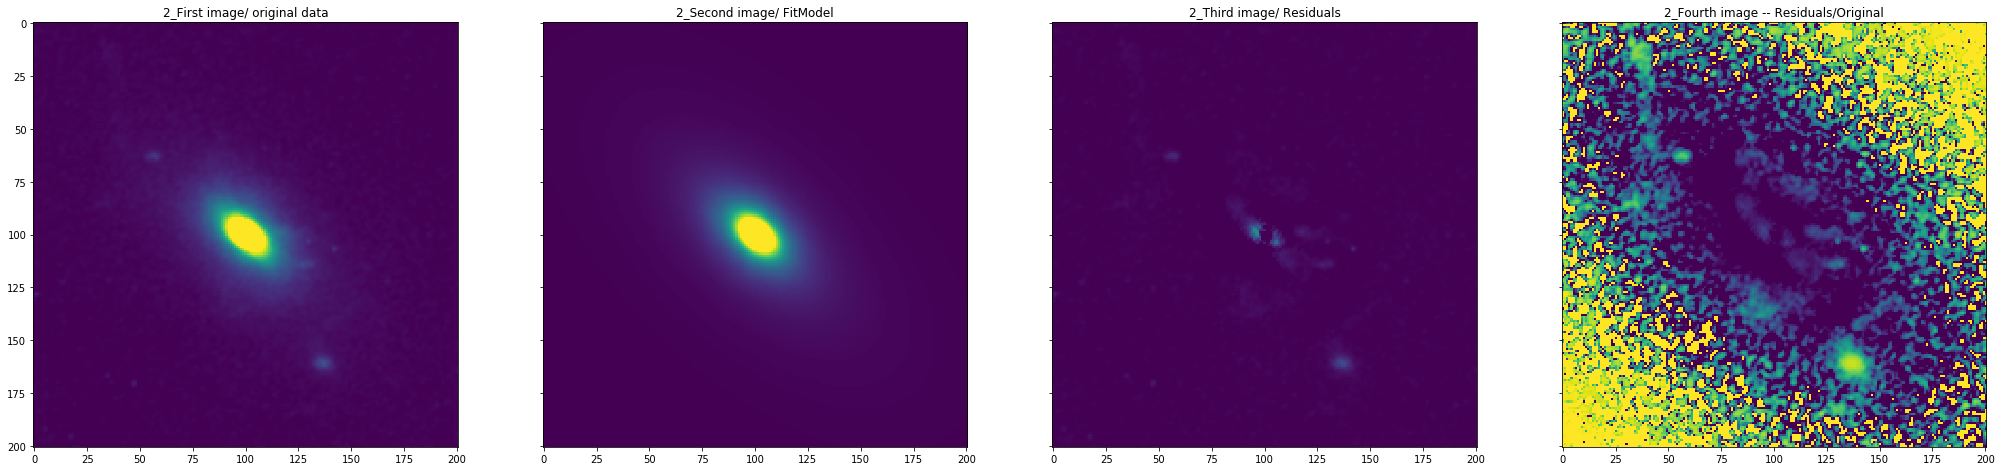

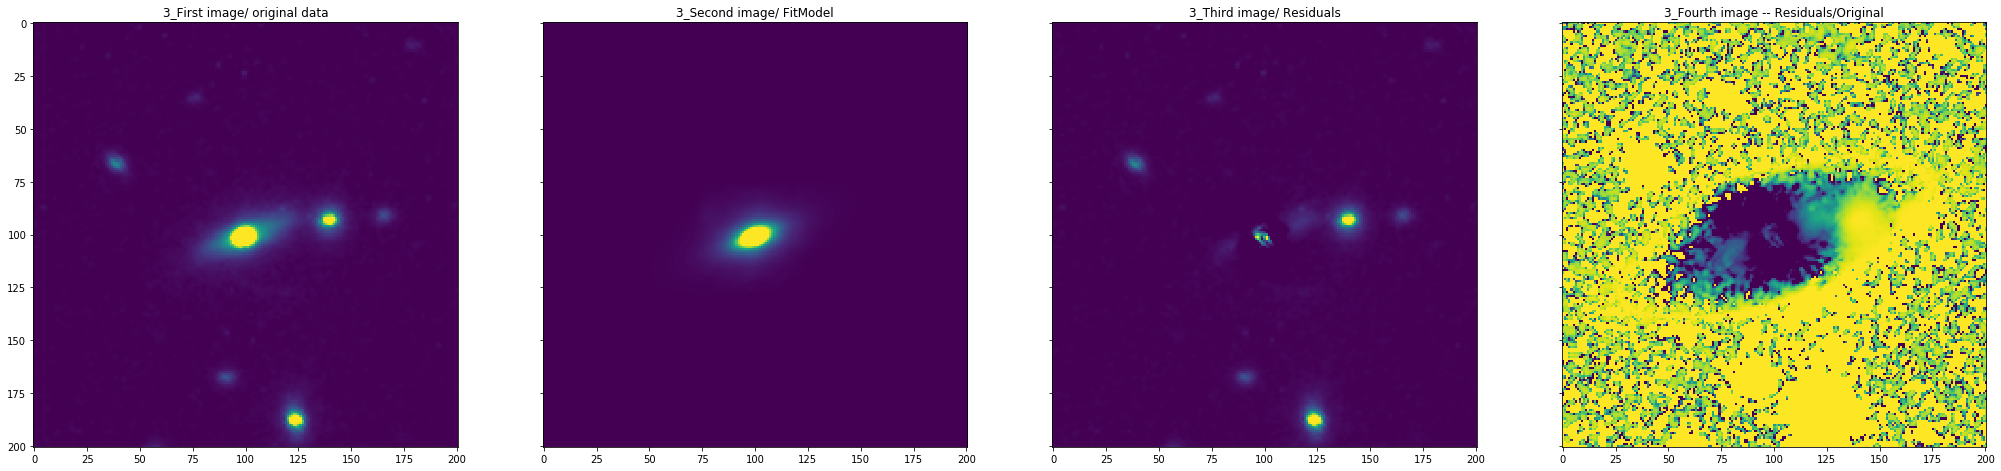

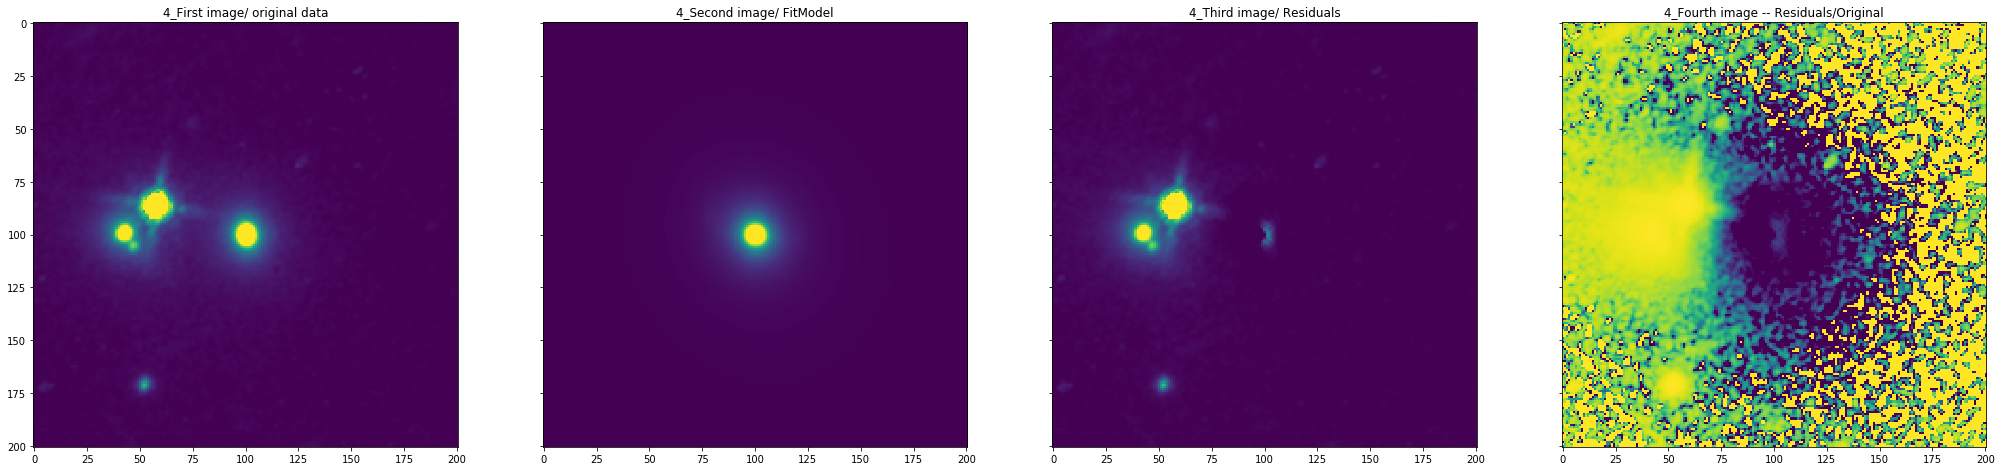

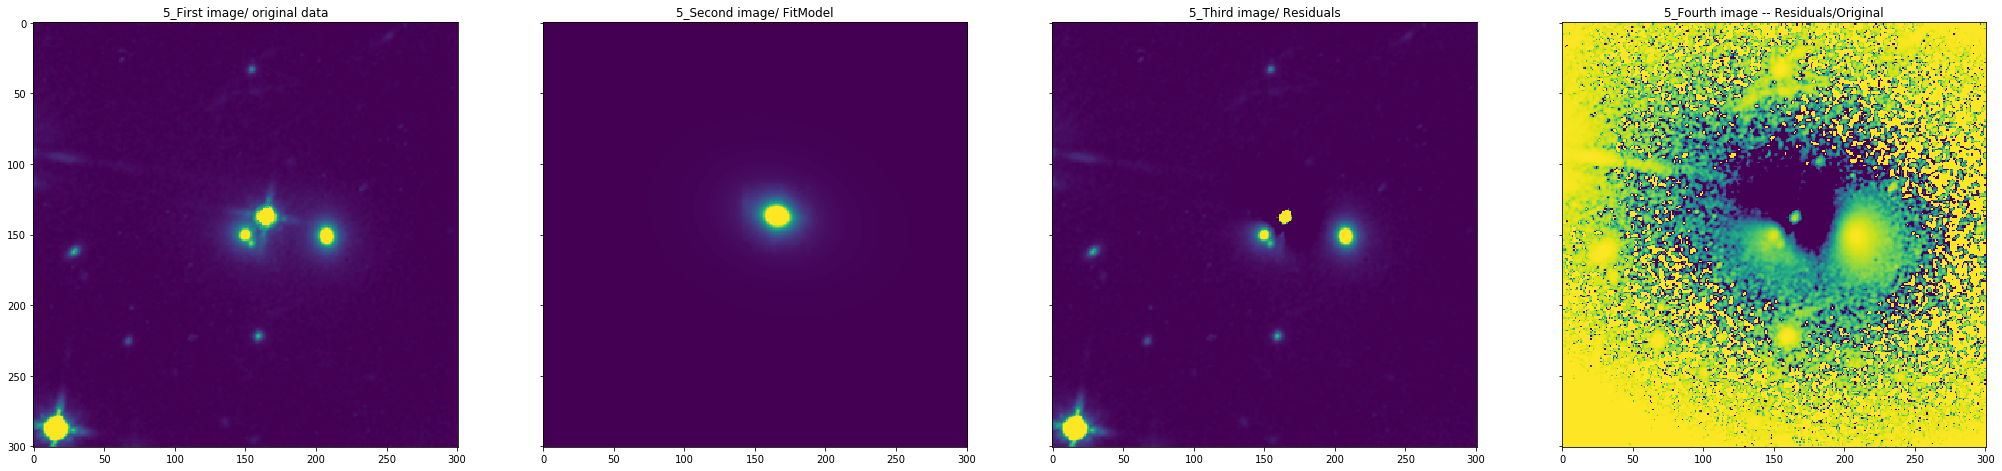

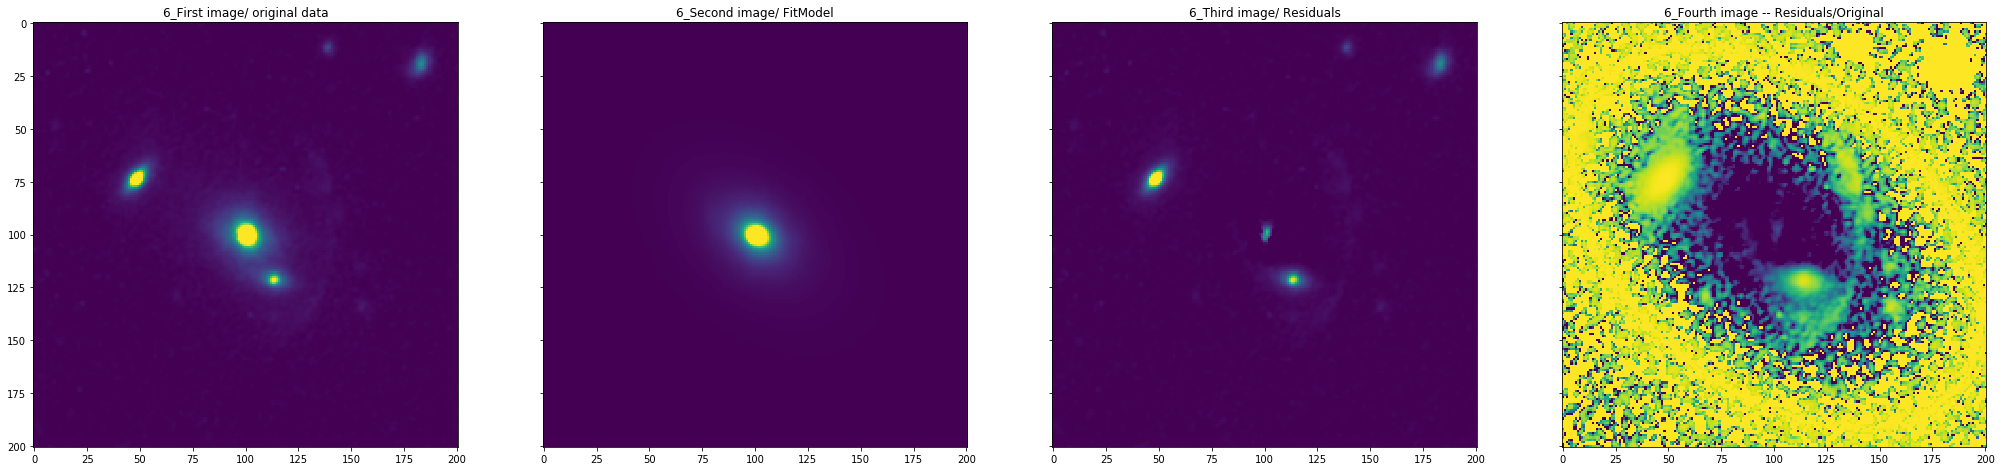

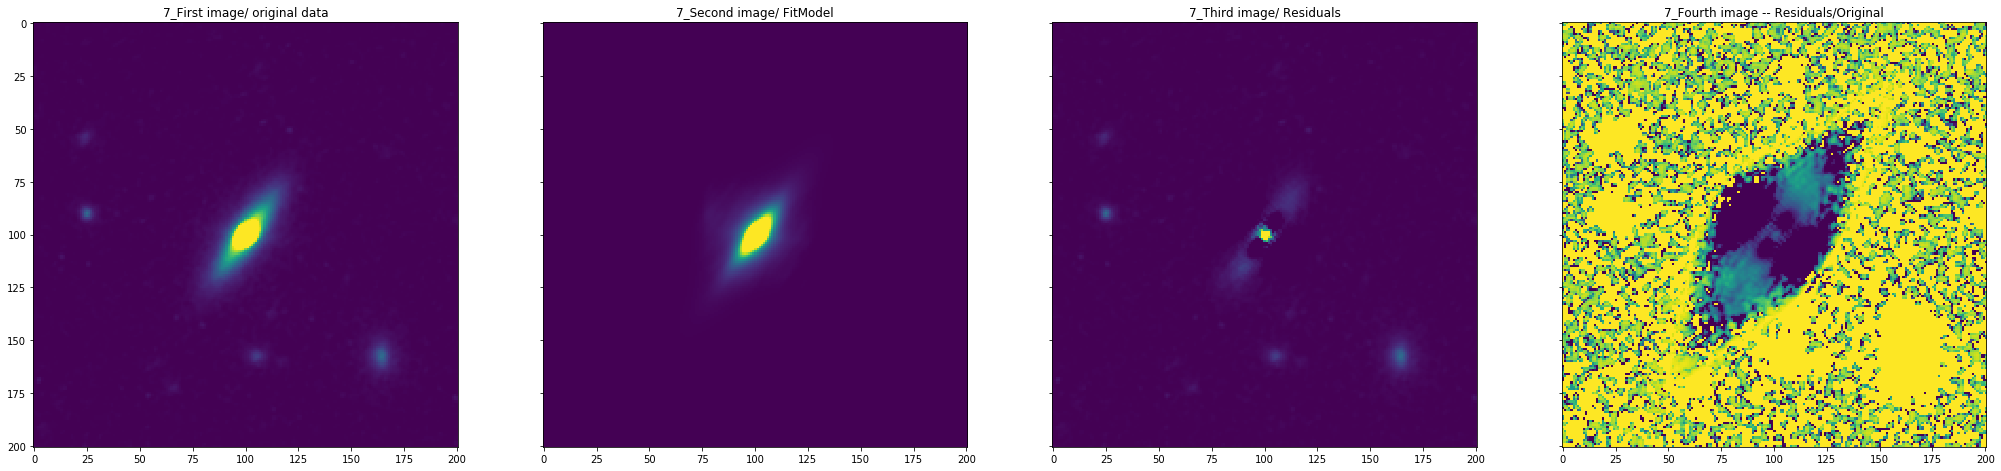

In [24]:
 
for count, item in enumerate(modelsList, 0):
    print(count)
    image = get_pkg_data_filename('/data1/rowland/{}/output{}.fits'.format(filtername,count))
    image_1 = pyfits.getdata(image, ext=1) #original
    image_2 = pyfits.getdata(image, ext=2) #model
    image_3 = pyfits.getdata(image, ext=3) #residuals
    image_4 = image_3 / image_1 #residuals divided by originals
    
    #plotting output images
    f, (ax1,ax2,ax3,ax4) = mpl.subplots(1,4,sharey=True,figsize=(35,35))
    ax1.imshow(image_1,vmin=0,vmax=1)
    ax1.title.set_text('{}_First image/ original data'.format(count))
    ax2.imshow(image_2,vmin=0,vmax=1)
    ax2.title.set_text('{}_Second image/ FitModel'.format(count))
    ax3.imshow(image_3,vmin=0,vmax=1)
    ax3.title.set_text('{}_Third image/ Residuals'.format(count))
    ax4.imshow(image_4,vmin=0,vmax=1)
    ax4.title.set_text('{}_Fourth image -- Residuals/Original'.format(count))
    mpl.savefig('/data1/rowland/{}/output{}_galfit_images'.format(filtername,count))
